# Project Proposal

At this project we, Itamar Davidyan (316463918) and Rotem Shai (204630115) decided to research the factors affecting happiness in world countries. For this goal we found dataset of the World Happiness Report and we got some more datasets from the UNdata website.

<br>

## Problem Description

The world economy has been growing consistently for many years and the world's population is in a state of "wealth" in relation to the past - but there are many countries where significant sections of the population are not happy with their life in the country. The purpose of this project is to find the factors of the increase in the happiness score among populations in different countries, and thus allow countries to invest their resources in the same factors which will cause to raise the happiness score of the citizens of the country.

<br>

## Data Collection

We collected our data from public websites:
* [World Happiness Report (via Kaggle)](https://www.kaggle.com/mathurinache/world-happiness-report) - Kaggle is the world's largest data science community with powerful tools and resources and a wide variety of datasets. For this project we downloaded the dataset of the 'World Happiness Report - 2020'.

  The yearly report is the product of a world-wide survey aimed to measure people's happiness by country.

  The report includes an overall happiness score, and provides 6 parameters that might have a certain relation to the score:
  1. GDP per capita
  2. Healthy Life Expectancy
  3. Social support
  4. Freedom to make life choices
  5. Generosity
  6. Corruption Perception

  According to [the report's official website](https://worldhappiness.report/), these parameters "reflect what has been broadly found in the research literature to be important in explaining national-level differences in life evaluations".

  The report indcludes 153 countries.
* [UNdata](http://data.un.org/Default.aspx) - an online data source, that includes data series from statistical databases provided by the UN System.

  We retreived data from several databases provided by UNdata:
  
  - Labour force and unemployment
  - Seats held by women in national parliament
  - Population, surface area and density

  Each database includes several data series. For this project we chose the following series, for each corresponding database:

  - Unemployment rate - Total (%)
  - Seats held by women in national parliament (%)
  - Population aged 0 to 14 years old (%), Population aged 60+ years old (%)


Let's upload the Kaggle dataset:


In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn as skl
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from matplotlib import patches as mpatches

In [2]:
happiness_df = pd.read_csv('https://github.com/rotemsha/sadna_data/blob/main/2020.csv?raw=true',error_bad_lines=False)
happiness_df = happiness_df.set_index('Country name')
happiness_df = happiness_df.filter(items=['Regional indicator', 'Ladder score', 
                                          'Logged GDP per capita', 'Social support',
                                          'Healthy life expectancy', 'Freedom to make life choices',
                                          'Generosity', 'Perceptions of corruption']) # keep only relevant columns
happiness_df = happiness_df.rename(columns={'Ladder score':'Happiness Score'})
happiness_df

,Regional indicator,Happiness Score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
Country name,,,,,,,,
Finland,Western Europe,7.8087,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445
Denmark,Western Europe,7.6456,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489
Switzerland,Western Europe,7.5599,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728
Iceland,Western Europe,7.5045,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710
Norway,Western Europe,7.4880,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218
...,...,...,...,...,...,...,...,...
Central African Republic,Sub-Saharan Africa,3.4759,6.625160,0.319460,45.200001,0.640881,0.082410,0.891807
Rwanda,Sub-Saharan Africa,3.3123,7.600104,0.540835,61.098846,0.900589,0.055484,0.183541
Zimbabwe,Sub-Saharan Africa,3.2992,7.865712,0.763093,55.617260,0.711458,-0.072064,0.810237


Let's upload the UN datasets and perform some basic cleaning:

In [3]:
labourforce_df = pd.read_csv('https://github.com/rotemsha/sadna_data/blob/main/un_laborforce.csv?raw=true',error_bad_lines=False)
labourforce_df.columns = labourforce_df.iloc[0]
labourforce_df.columns = labourforce_df.columns.fillna('Name')
labourforce_df = labourforce_df.drop(labourforce_df.index[0])
labourforce_df = labourforce_df[labourforce_df['Year'] == '2020'] # use only data from 2020
labourforce_df = labourforce_df.loc[labourforce_df['Series'] == 'Unemployment rate - Total'] # use only total unemployment rate
labourforce_df = labourforce_df.set_index('Name')
labourforce_col_name = 'Unemployment rate (%)'

labourforce_df = labourforce_df.rename(columns={'Value': labourforce_col_name})
labourforce_df = labourforce_df.filter(items=[labourforce_col_name])

We can now perform a similar process with the rest of the un data:


In [4]:
un_women_par_df = pd.read_csv('https://github.com/rotemsha/sadna_data/blob/main/un_women_parliament.csv?raw=true',error_bad_lines=False)
un_women_par_df.columns = un_women_par_df.iloc[0]
un_women_par_df.columns = un_women_par_df.columns.fillna('Name')
un_women_par_df = un_women_par_df.drop(un_women_par_df.index[0])
un_women_par_df = un_women_par_df[un_women_par_df['Year'] == '2020']
un_women_par_df = un_women_par_df.set_index('Name')

un_women_par_col_name = 'Seats held by women in national parliament (%)'
un_women_par_df = un_women_par_df.rename(columns={'Value':
                                                  un_women_par_col_name})
un_women_par_df = un_women_par_df.filter(items=[un_women_par_col_name])
un_women_par_df[un_women_par_col_name] = pd.to_numeric(un_women_par_df[un_women_par_col_name])


In [5]:
un_population_df = pd.read_csv('https://github.com/rotemsha/sadna_data/blob/main/un_population.csv?raw=true',error_bad_lines=False)
un_population_df.columns = un_population_df.iloc[0]
un_population_df.columns = un_population_df.columns.fillna('Name')
un_population_df = un_population_df.drop(un_population_df.index[0])
un_population_df = un_population_df[un_population_df['Year'] == '2020']
un_population_df = un_population_df.set_index('Name')

un_population_kids_col_name = 'Population aged 0 to 14 years old (percentage)'
un_population_df_kids = un_population_df.loc[un_population_df['Series'] == un_population_kids_col_name]
un_population_df_kids = un_population_df_kids.rename(columns={'Value':
                                                  un_population_kids_col_name})
un_population_df_kids = un_population_df_kids.filter(items=[un_population_kids_col_name])
un_population_df_kids[un_population_kids_col_name] = pd.to_numeric(un_population_df_kids[un_population_kids_col_name])
un_population_df_kids = un_population_df_kids.rename(columns={un_population_kids_col_name: un_population_kids_col_name.replace('percentage', '%')})

un_population_old_col_name = 'Population aged 60+ years old (percentage)'
un_population_df_old = un_population_df.loc[un_population_df['Series'] == un_population_old_col_name]
un_population_df_old = un_population_df_old.rename(columns={'Value':
                                                  un_population_old_col_name})
un_population_df_old = un_population_df_old.filter(items=[un_population_old_col_name])
un_population_df_old = un_population_df_old.rename(columns={un_population_old_col_name: un_population_old_col_name.replace('percentage', '%')})

old_population_col_name = 'Population aged 60+ years old (%)'
un_population_df_old[old_population_col_name] = pd.to_numeric(un_population_df_old[old_population_col_name])


Notice that un-DataFrames contains different countries regions than happiness_df.

We would want to merge the dfs, so we'll see what is the symetric difference between the lists:

In [6]:
def handle_countries_diff(main_df, secondary_df):
  main_countries = set(main_df.index.tolist())
  secondary_countries_list = secondary_df.index.tolist()
  secondary_countries = set(secondary_countries_list)
  missing_in_main = main_countries - secondary_countries
  # print(f'missing in main df: {missing_in_main}')
  missing_in_secondary = secondary_countries - main_countries
  # print(f'missing in secondary df: {missing_in_secondary}')
  return missing_in_main, missing_in_secondary

missing_in_kaggle_data, missing_in_labour_data = \
 handle_countries_diff(happiness_df, labourforce_df)
missing_in_kaggle_data

{'Bolivia',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Czech Republic',
 'Hong Kong S.A.R. of China',
 'Iran',
 'Ivory Coast',
 'Kosovo',
 'Laos',
 'Macedonia',
 'Moldova',
 'North Cyprus',
 'Palestinian Territories',
 'Russia',
 'South Korea',
 'Swaziland',
 'Taiwan Province of China',
 'Tanzania',
 'United States',
 'Venezuela',
 'Vietnam'}

In [7]:
missing_in_labour_data

{'Africa',
 'Americas',
 'Angola',
 'Bahamas',
 'Barbados',
 'Belize',
 'Bhutan',
 'Bolivia (Plurin. State of)',
 'Brunei Darussalam',
 'Cabo Verde',
 'Caribbean',
 'Caucasus',
 'Central America',
 'Central Asia',
 'Channel Islands',
 'China, Hong Kong SAR',
 'China, Macao SAR',
 'Congo',
 'Cuba',
 'Czechia',
 'Côte d’Ivoire',
 "Dem. People's Rep. Korea",
 'Dem. Rep. of the Congo',
 'Djibouti',
 'Eastern Africa',
 'Eastern Asia',
 'Eastern Europe',
 'Equatorial Guinea',
 'Eritrea',
 'Eswatini',
 'European Union (EU)',
 'Fiji',
 'French Polynesia',
 'Guam',
 'Guinea-Bissau',
 'Guyana',
 'Iran (Islamic Republic of)',
 "Lao People's Dem. Rep.",
 'Latin America & the Caribbean',
 'Middle Africa',
 'New Caledonia',
 'North Macedonia',
 'Northern Africa',
 'Northern America',
 'Oceania',
 'Oman',
 'Papua New Guinea',
 'Puerto Rico',
 'Qatar',
 'Republic of Korea',
 'Republic of Moldova',
 'Russian Federation',
 'Saint Lucia',
 'Saint Vincent & Grenadines',
 'Samoa',
 'Sao Tome and Principe',

We can see that some of the differences are a result of slightly different 
names.
Since not much data is missing in the UN database, we'll update it manually:

In [8]:
updated_names = {'Bolivia (Plurin. State of)': 'Bolivia',
                 'Czechia': 'Czech Republic',
                 'China, Hong Kong SAR': 'Hong Kong S.A.R. of China',
                 'Iran (Islamic Republic of)': 'Iran',
                 'Côte d’Ivoire': 'Ivory Coast',
                 "Lao People's Dem. Rep.": 'Laos',
                 'North Macedonia': 'Macedonia',
                 'Republic of Moldova': 'Moldova',
                 'Russian Federation': 'Russia',
                 'South Korea': 'Republic of Korea',
                 'Eswatini': 'Swaziland',
                 'United Rep. of Tanzania': 'Tanzania',
                 'United States of America': 'United States',
                 'Venezuela (Boliv. Rep. of)' :'Venezuela',
                 'Viet Nam': 'Vietnam',
                 'Republic of Korea': 'South Korea',
                 'State of Palestine': 'Palestinian Territories'}
labourforce_df = labourforce_df.rename(index=updated_names)


Let's see the countries that remains lost:

In [9]:
missing_in_kaggle_data, _ = handle_countries_diff(happiness_df, labourforce_df)
missing_in_kaggle_data

{'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Kosovo',
 'North Cyprus',
 'Taiwan Province of China'}

We'll rename the index in the rest of the UN DataFrames as well:

In [10]:
un_women_par_df = un_women_par_df.rename(index=updated_names)
un_population_df_kids = un_population_df_kids.rename(index=updated_names)
un_population_df_old = un_population_df_old.rename(index=updated_names)
un_women_par_df = un_women_par_df.rename(index=updated_names)

Yay! we can now merge the Dataframe to a one big happy DataFrame.

We'll do so with in 'inner' merge so we don't get null values. We'll do the merge and check how much data is lost from the original DataFrame:

In [11]:
print(f'size of original df is: {len(happiness_df)}')
df = happiness_df.merge(labourforce_df, how='inner', left_index=True, right_index=True)
df = df.merge(un_women_par_df, how='inner', left_index=True, right_index=True)
df = df.merge(un_population_df_kids, how='inner', left_index=True, right_index=True)
df = df.merge(un_population_df_old, how='inner', left_index=True, right_index=True)
df = df.rename_axis('Name').reset_index()
print(f'size of merged df is: {len(df)}')
df

size of original df is: 153
size of merged df is: 145


,Name,Regional indicator,Happiness Score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Unemployment rate (%),Seats held by women in national parliament (%),Population aged 0 to 14 years old (%),Population aged 60+ years old (%)
0,Finland,Western Europe,7.8087,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,6.6600,46.00,15.8651,28.9914
1,Denmark,Western Europe,7.6456,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,4.8500,39.66,16.2817,26.1324
2,Switzerland,Western Europe,7.5599,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,4.8500,41.50,14.9586,25.2887
3,Iceland,Western Europe,7.5045,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,3.2200,38.10,19.4243,21.6034
4,Norway,Western Europe,7.4880,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,3.3100,41.42,17.2571,23.2666
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Central African Republic,Sub-Saharan Africa,3.4759,6.625160,0.319460,45.200001,0.640881,0.082410,0.891807,3.7000,8.57,43.5417,4.4743
141,Rwanda,Sub-Saharan Africa,3.3123,7.600104,0.540835,61.098846,0.900589,0.055484,0.183541,1.0400,61.25,39.4742,5.1208
142,Zimbabwe,Sub-Saharan Africa,3.2992,7.865712,0.763093,55.617260,0.711458,-0.072064,0.810237,4.9900,31.85,41.9111,4.6319
143,South Sudan,Sub-Saharan Africa,2.8166,7.425360,0.553707,51.000000,0.451314,0.016519,0.763417,12.2600,28.46,41.3278,5.1518


We lost 8 countries. It's a bummer, but we can live with it.

We can also see that there are no null values in the table:

In [12]:
df.isnull().sum()

Name                                              0
Regional indicator                                0
Happiness Score                                   0
Logged GDP per capita                             0
Social support                                    0
Healthy life expectancy                           0
Freedom to make life choices                      0
Generosity                                        0
Perceptions of corruption                         0
Unemployment rate (%)                             0
Seats held by women in national parliament (%)    0
Population aged 0 to 14 years old (%)             0
Population aged 60+ years old (%)                 0
dtype: int64

## Initial Data Analysis

Let's perform some basic analysis of our data.

We'll start by looking at the happiest countries and regions.

In all plots, we'll dedicate a different color for each region.


In [13]:
def get_regions_colors(df):
  import matplotlib.colors as mcolors
  colors = list(mcolors.TABLEAU_COLORS.keys())
  regions = list(df['Regional indicator'].unique())
  zip_iterator = zip(regions, colors)
  region_colors = dict(zip_iterator)
  return region_colors


def show_plot(df):
  region_colors = get_regions_colors(df)
  x = 'Name' if 'Name' in df else 'Regional indicator'
  df.plot(kind='barh', x=x, y='Happiness Score',
                  figsize=(15,7),
                  color=[region_colors[i] for i in df['Regional indicator']])

  handles = [mpatches.Patch(color=region_colors[i]) for i in region_colors]
  region_labels = [i for i in region_colors]
  plt.legend(handles, region_labels)
  for index, value in enumerate(df['Happiness Score']):
      plt.text(value, index, f'{value:.02f}')

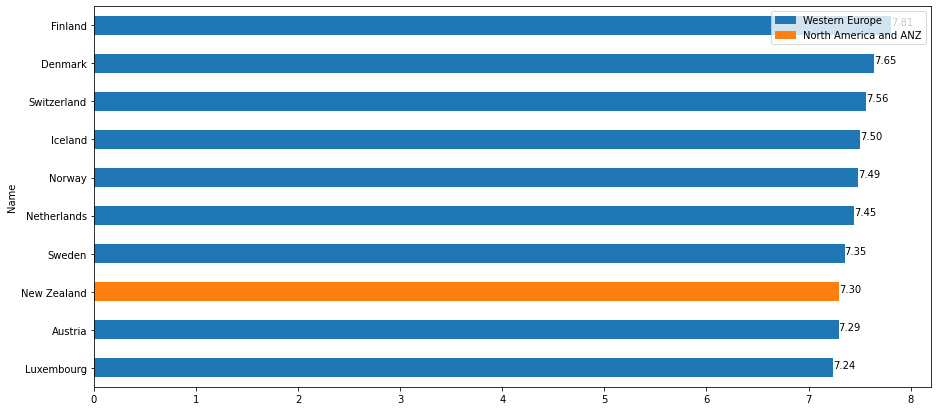

In [14]:
happiest = df.nlargest(10, 'Happiness Score')
happiest = happiest.sort_values(by=['Happiness Score'])
show_plot(happiest)

10 unhappiest countries:

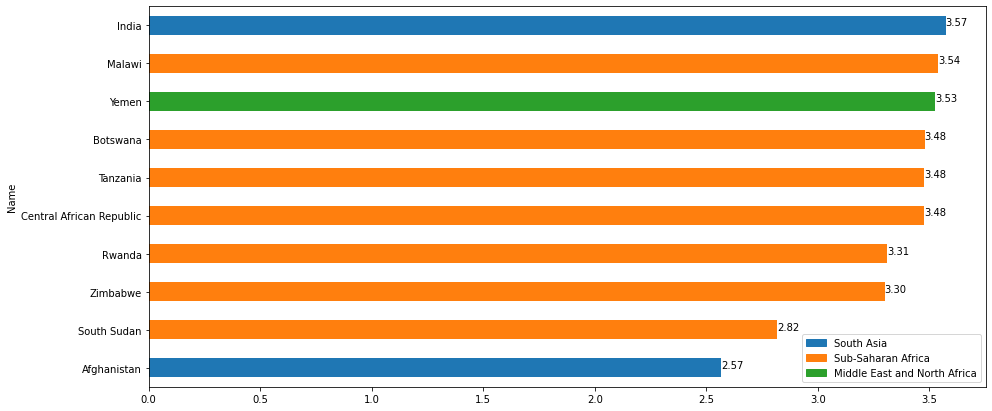

In [15]:
unhappiest = df.nsmallest(10, 'Happiness Score')
unhappiest = unhappiest.sort_values(by=['Happiness Score'])
show_plot(unhappiest)

Let's look at the happiest\unhappiest regions:

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

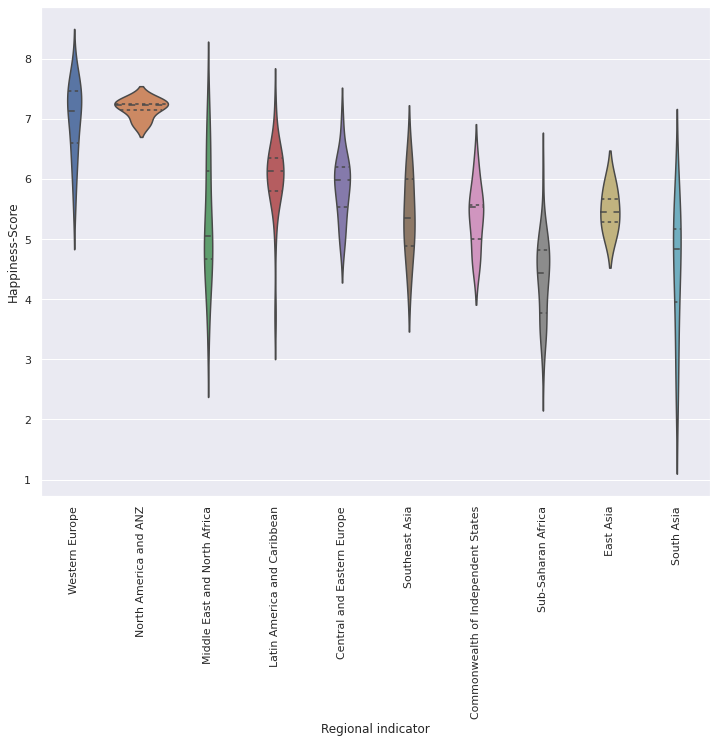

In [16]:
sns.set(rc={'figure.figsize':(12,9)})
data = pd.melt(df, id_vars='Regional indicator', value_vars='Happiness Score', value_name='Happiness-Score')
sns.violinplot(x="Regional indicator", y="Happiness-Score", data=data, split=True, inner="quart")
plt.xticks(rotation=90)

From the above graph we can conclude conclusions:

*   At North America and ANZ all the countries get happines score between 6 to 8
*   At South Asia there is the biggest diffrence between countries.
*   At Westren Europe there is the country with highest happines score.
*   At South Asis there is the country with the lowest happines score.

In [17]:
hover_data = df[["Happiness Score"]]

fig = px.choropleth(df,
                    locations=df["Name"],
                    locationmode="country names",
                    projection="natural earth",
                    hover_data=hover_data,
                    hover_name=df["Name"],
                    color="Happiness Score",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    scope="world")
fig.show()

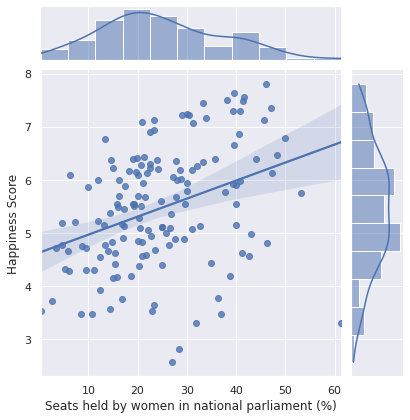

In [18]:
sns.jointplot(x = df.loc[:,'Seats held by women in national parliament (%)'], y = df.loc[:,'Happiness Score'], kind="reg")

From the 2 above graphs we can't conclude unambiguous conclusion because there is no correlation between the columns values.

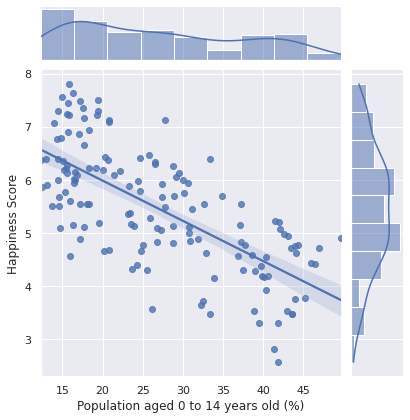

In [19]:
sns.jointplot(x = df.loc[:,'Population aged 0 to 14 years old (%)'], y = df.loc[:,'Happiness Score'], kind="reg")

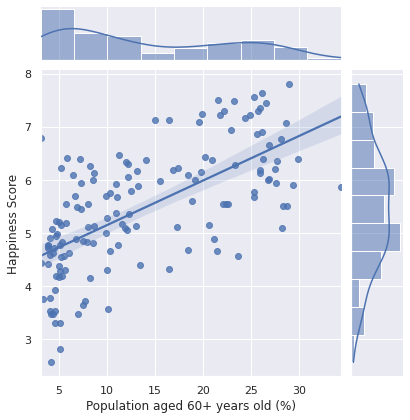

In [20]:
sns.jointplot(x = df.loc[:,'Population aged 60+ years old (%)'], y = df.loc[:,'Happiness Score'], kind="reg")

From the 2 above graphs we can conclude conclusions:
*   The more the child population occupies a wider share of the country’s population - the happiness score is lower.
*   The more the 60+ population occupies a wider share of the country’s population - the happiness score is higher.

Now let's find correlation between Happiness Score to other columns
If the value is near to 1 or -1 it's show that there is correlation between the params
(For convenient analysis of the data we absolute the correlation value and arrange in descending order)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

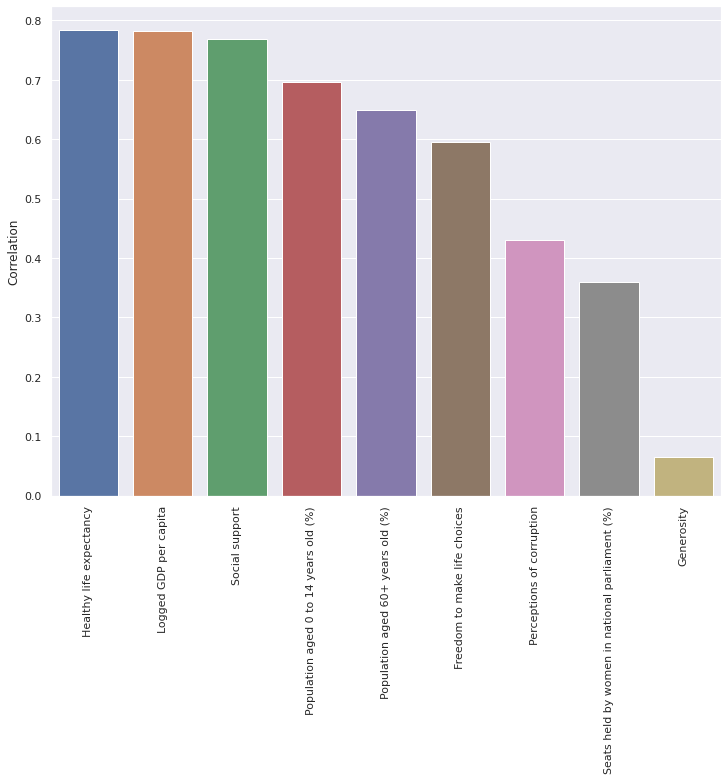

In [21]:
corr_data = df.corr()['Happiness Score'].drop('Happiness Score')
corr_data = corr_data.to_frame(name='Correlation').abs().sort_values(by='Correlation', ascending=False)
sns.barplot(x=corr_data.index, y="Correlation", data=corr_data)
plt.xticks(rotation=90)

## PCA

At first, we tried to visualize our data a bit. To do that, we needed to reduce the dimensions of the data. we did so by using PCA.

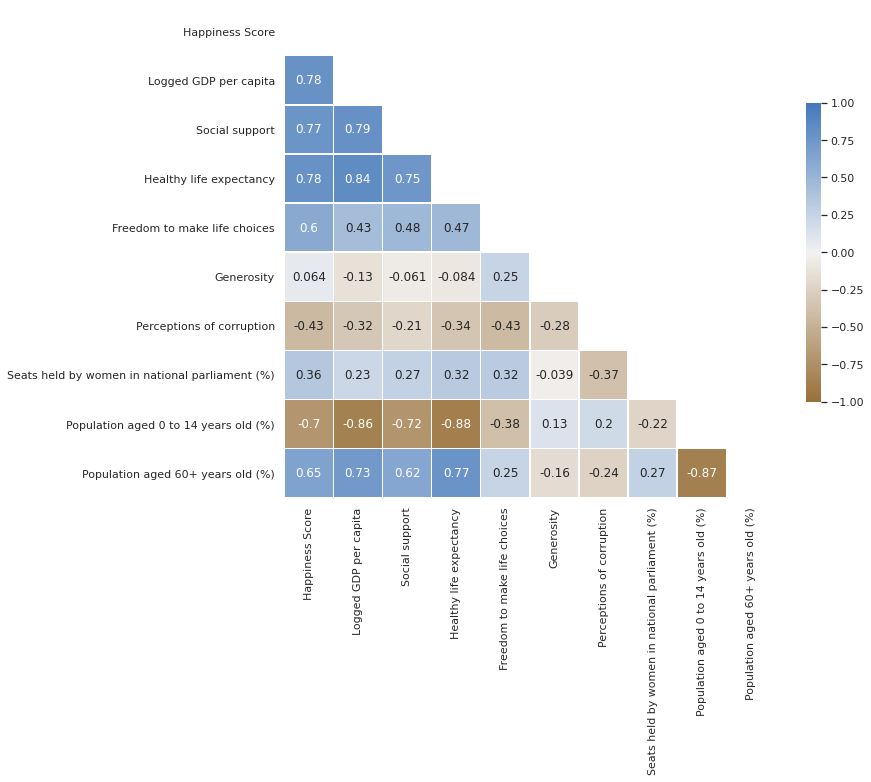

In [22]:
sns.set(style="white")

# Compute the correlation matrix
new_all = df.drop(['Name', 'Regional indicator'],axis=1)
corr = new_all.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(50, 250, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, 
           square=True, linewidths=0.5, cbar_kws={"shrink": .5}, annot=True)

In [23]:
num_of_trains = 1000

In [24]:
def train_decision_tree_classifier():
  x = df.drop(columns=['Happiness Score', 'Name', 'Regional indicator'])
  y = df['Happiness Score'].apply(np.round)
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

  model = DecisionTreeClassifier()
  model.fit(x_train, y_train)
  predictions = model.predict(x_test)

  return accuracy_score(y_test, predictions)

scores = pd.Series([train_decision_tree_classifier() for i in range(num_of_trains)])
scores.mean()

0.49958620689655164

In [25]:
def train_decision_tree_regressor():
  x = df.drop(columns=['Happiness Score', 'Name', 'Regional indicator'])
  y = df['Happiness Score']
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

  model = DecisionTreeRegressor()
  model.fit(x_train, y_train)
  predictions = model.predict(x_test)

  return r2_score(y_test, predictions)

scores = pd.Series([train_decision_tree_regressor() for i in range(num_of_trains)])
scores.mean()

0.5307158930825181

From the above 2 decision trees we didn't get satisfactory score (around 0.5 from 1)

Thoughts for future work:
*   Collect more relevant data (like `un_population_df`)
*   Merge with data from previous years.
*   Try using different models.